# Регрессия - пора творить!

Если вы дошли до этой практики и выполнили все предыдущие - вау! Аплодисменты вам!

<p align="center"><img src="https://s3.wi-fi.ru/cp3o/zqEeEKCkhPUnnwD3dHmuEmQq?response-content-type=image%2Fjpeg" width=500/></p>



Тем не менее, не время расслабляться! На этот раз, мы не будем рассказывать вам новый материал - лишь дадим пару напутствий и пожелаем успехов и сил!

В этот раз вам предлагается разработать модель предсказания цены домов по набору данных Boston Houses Pricing. Мы его уже немного пощупали в прошлой практике, но в этой вам предстоит сделать всё самостоятельно и на полных данных!

Что надо будет сделать:
- Загрузить данные
- Посмотреть и размер, и примеры данных
- Проверить количество пропусков в данных
    - Убедиться, что пропусков в данных нет и можно строить **baseline**
- Делим данные на train и test 
    - Делаем это один раз! Все дальнейшие модификации и улучшения должны делаться на основе единственного разделения!
    - И не забудьте зафиксировать сид! Переменную `RANDOM_SEED` мы даём ниже
- Создаем baseline модель, снимаем метрики на тестовой выборке
- Производим анализ данных, готовим план по очистке и предобработке данных
- Создаем функцию очистки
- Производим очистку train и test выборок -> обучаем модель с очищенными данными
    - Снимаем метрики и так мы оцениваем влияние очистки данных на обучение
- Создаем класс предобработки данных
- Производим предобработку очищенных данных -> обучаем модель
    - Снимаем метрики и так мы оцениваем влияние предобработки данных на обучение

А дальше можете пофантазировать, почитать интернет и посмотреть, как улучшить метрики! 

**Ваша цель - достигнуть наилучших показателей!**

Вот вам пара идей по интересной организации предобработке:
- По признаку `CRIM` создать признак `is_CRIM`, который будет равен 1, если `CRIM` не равен 0 и 0, если `CRIM` равен нулю
- Сделать обучение модели [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), посмотреть, какие признаки имеют веса близкие к 0 и убрать их из обучения как незначимые
- Оставить только признаки с высокой корреляцией с целевой переменной
- Посмотреть, какие переменные коррелирцют между собой и оставить только единственные из пар коррелирующих
- Посмотреть, в каких примерах данных модель ошибается сильнее всего (отсортировать записи из теста по величине ошибки) и проанализировать, есть ли какая-то зависимость или шум
- Комбинировать разные подходы в зависимости от того, помогает это предсказаниям или нет

Ещё большим плюсом будет, если вы покажете, как влияет каждый этап предобработки на результаты обучения!

In [1]:
# Зафиксируем состояние случайных чисел
import numpy as np
import random

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
import seaborn as sns
TEXT_COLOR = 'white'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = TEXT_COLOR
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.markersize'] = 15
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR
sns.set_style('darkgrid')

Что мы ждем от вас? 

Готовый ноутбук с таким же названием, в котором будут обязательные пункты с выводами по анализу данных и анализу поведения модели, а также дополнительные пункты по вашим размышлениям и процессу улучшения модели.

Успехов вам, мы в вас верим и уверены, что вы точно справитесь!

<p align="center"><img src="https://raw.githubusercontent.com/kail4ek/ml_edu/master/assets/cat-computer-peek-out-36960208.jpg" width=600/></p>

In [3]:
#Прочитаем данные и познакомимся с ними
df = pd.read_csv('boston.csv',index_col=0)

In [4]:
#Посмотрим на размер данных
df.shape

(506, 14)

В наших данных 14 фич или признаков и 506 экземпляров

Посмотрим какие признаки у нас есть

In [5]:
df.head(5)

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
1  396.90   4.98  24.0  
2  396.90   9.14  21.6  
3  392.83   4.03  34.7  
4  394.63   2.94  33.4  
5  396.90   5.33  36.2

 Где:
 - crim - уровень преступности на душу населения по городам
- zn - доля жилой земли, зонированной для участков площадью более 25 000 кв. футов.
- indus - доля акров нетоварного бизнеса в городе
- chas - переменная-флаг приближенности к реке (= 1 если рядом с рекой; 0 в ином случае)
- nox - концентрация оксидов азота (частей на 10 миллионов)
- rm - среднее количество комнат в одном жилом помещении
- age - доля квартир, занятых владельцами, построенных до 1940 года
- dis - взвешенные расстояния до пяти бостонских центров занятости
- rad - индекс доступности радиальных магистралей
- tax - недвижимость с полной стоимостью-ставка налога за 10 000 долларов США
- ptratio - соотношение числа учащихся и учителей по городам
- black - 1000(Bk - 0.63)^2, где Bk - доля чернокожего населения по городам
- lstat - процент бедности населения
- medv - средняя стоимость домов, занятых владельцами, в 1000 долларов США

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 1 to 506
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 59.3 KB


Просмотрев информацию о данных, видно, что в них отсутствуют пропуски, но проверим еще пропуски с помощью .isnull()

In [7]:
df.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

В отстуствии пропусков в данных убедились

In [8]:
df.describe()

crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              age         dis         rad         tax     ptratio       black  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            lstat        medv  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

Разделим данные на тестовые и тренировочные части, пока не приступили к обработке, анализу данных, в ходе которой данные могут измениться

In [9]:
df_train_data, df_test_data = train_test_split(df, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
print(f'Выбора обучения:{df_train_data.shape}, Тестовая выборка: {df_test_data.shape}')

Выбора обучения:(354, 14), Тестовая выборка: (152, 14)


Построим baseline:

In [10]:
baseline_medv = np.mean(df['medv'])
print('The baseline medv is a score of %0.2f' %baseline_medv)

The baseline medv is a score of 22.53


Получили, что средняя стоимость дома равняется 22530$

Проведем унивариантный анализ данных.

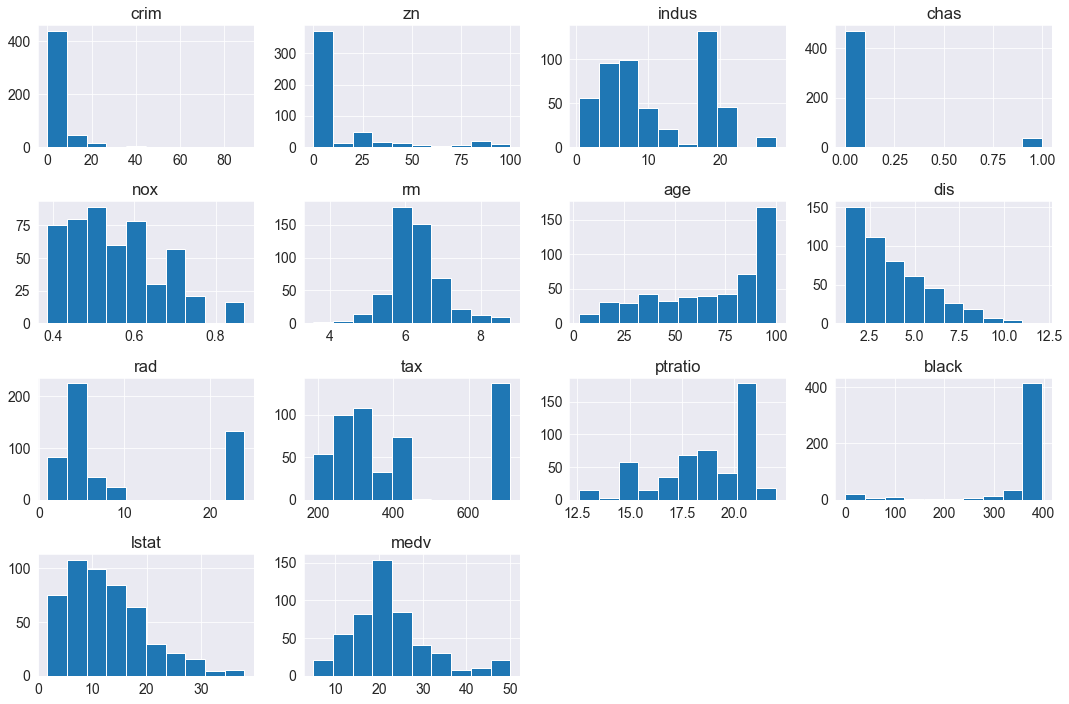

In [11]:
df.hist()
plt.tight_layout()

По графикам распределения данных можно заметить следующее:
- medv, rm имеют нормальное распределение
- dis, nox, lstat - имеют левое смещение
- crim можно представить в виде бинарного распределения
- chas - бимодальное распределение
- age имеет правое смещение
- indus - бимодальное распределение
- rad - ассиметричное распределение с выбросом
- tax - близко к бимодальному
- zn - ассиметрично со смещением влево

Проведем анализ нескольких переменных (мультивариантный)

Построим матрицы корреляции

<AxesSubplot:>

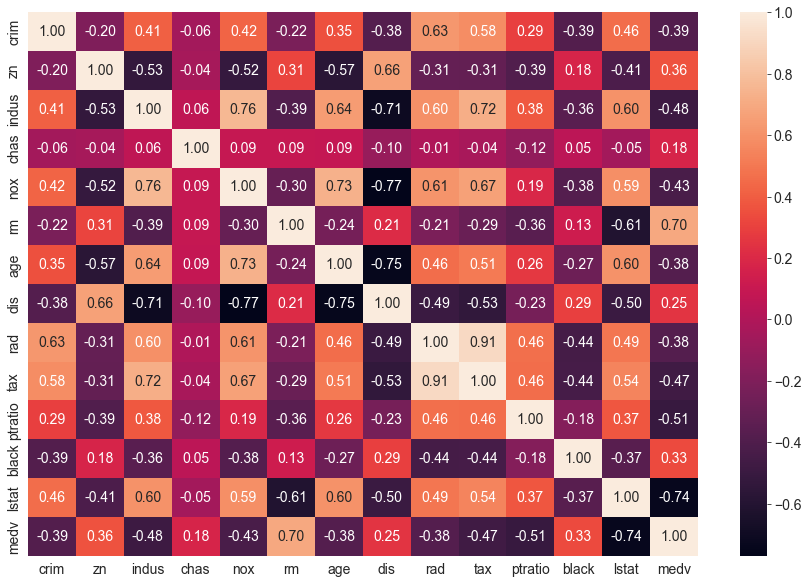

In [12]:
#матрица корреляции Пирсона
correlation_mtrx_1 = df.corr()
sns.heatmap(correlation_mtrx_1, annot=True, fmt='.2f')

- видим, что сильная взаимосвязь между dis и nox,dis и indus, dis и age, indus и nox,  age и nox, так как у признака nox больше взаимосвязь с другими признаками, поэтому его мы исключим из анализа
- на medv больше всего влияет lstat, так же влияет rm

<AxesSubplot:>

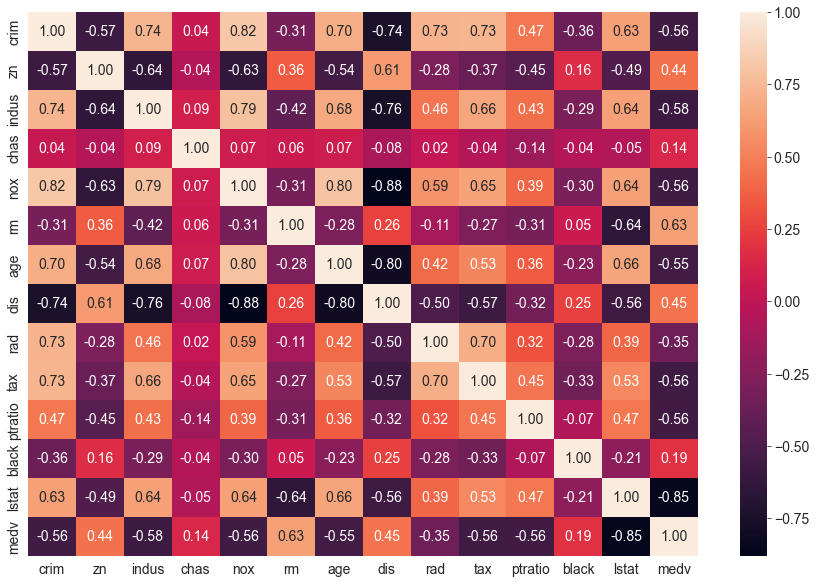

In [13]:
#матрица корреляции Спирмана
correlation_mtrx_2 = df.corr(method='spearman')
sns.heatmap(correlation_mtrx_2, annot=True, fmt='.2f')

Результат остался почти таким же

In [14]:
#матрица корреляции Кендала
#correlation_mtrx_3 = df.corr(method='kendall')
#sns.heatmap(correlation_mtrx_3, annot=True, fmt='.2f')

Посмотрим на метрики(MSE,MAE,RMSE,R2):

In [15]:
#функция вычисления метрик
def df_metrics(true, predict):
    metrics = {
        'MSE': round(mean_squared_error(true, predict), 3),
        'MAE': round(mean_absolute_error(true, predict), 3),
        'RMSE': round(np.sqrt(mean_squared_error(true, predict)), 3),
        'R2': round(r2_score(true, predict), 3)}
    return pd.Series(metrics)

In [16]:
y_tr = df.medv
y_pr = baseline_medv * np.ones_like(y_tr)

metrics_baseline = df_metrics(y_tr, y_pr)
print(metrics_baseline)

MSE     84.420
MAE      6.647
RMSE     9.188
R2       0.000
dtype: float64


По полученной информации из данных можем сделать следующие выводы:

- В данных нет пропусков
- BASELINE - средняя стоимость = 22.5
- RMSE = 9.1880
- Наибольшая корреляция в парах rad-tax, medv(целевая)-lstat, age-dis-nox-indus
- Распределение целевой величины близко к нормальному


Для линейной регресси medv(rm) необходимо выделить целевую переменную и необходимый признак
Для реализации зависимости medv(lstat) необходимо признак lstat привести к форме полинома второй степени


Что можно сделать в предобратке данных:

- Убрать выбросы в данных
- Удалить признаки с большой корреляцией
- Применить Lasso
- свести признак crim к бинарному виду


In [17]:
chas = df.pop('chas')

Очистим от выбросов:

In [18]:
#функция удаления выбросов
def clean_dataset(df):
    
    mask_1 = df.medv == 50
    mask_2 = df.rm < 4
    mask_3 = (df.rm > 8) & (df.medv < 30)

    mask = mask_1 | mask_2 | mask_3

    df = df[~mask]
    return df

In [19]:
df_train = clean_dataset(df_train_data)
df_test = clean_dataset(df_test_data)

In [20]:
sns.pairplot(pd.concat([df_train, df_test]), hue = 'medv', corner = True, height = 10)

Так как некоторые пары признаков имеют высокий коэффициент корреляции их следует удалить (rad, dis, age)

Корреляция с целевой:

- RAD: 0.38
- TAX: 0.47
- AGE: 0.38
- DIS: 0.25
- NOX: 0.43
- INDUS: 0.48


Удалим колонки с высокой корреляцией:

In [21]:

drop_columns = ['rad', 'dis', 'age']

#функция удаления колонок

def drop_corr_columns(df, columns):
    df = df.drop(columns, axis=1)
    return df

df_train = drop_corr_columns(df_train, drop_columns)

Воспользуемся Lasso для удаления признаков с малым весом

In [22]:
#функция Лассо
def lasso_(df):
    
    df_x = df.copy().drop('medv', axis=1)
    
    lasso = Lasso(alpha = 1)

    lasso.fit(df_x, df.medv)
    coef = pd.Series(lasso.coef_, index = df_x.columns,)
    coef = coef.loc[abs(coef)>0.05]
    _columns = list(coef.index) + ['medv']
    return _columns

In [23]:
df_columns = lasso_(df_train)
df_train = df_train[df_columns]
df_test = df_test[df_columns]
df_train.head()

crim     rm  ptratio  lstat  medv
6     0.02985  6.430     18.7   5.21  28.7
117   0.13158  6.176     17.8  12.04  21.2
46    0.17142  5.682     17.9  10.21  19.3
17    1.05393  5.935     21.0   6.58  23.1
469  15.57570  5.926     20.2  18.13  19.1

Проведем бинаризацию crim:

In [24]:
#функция бинаризации 
def crim_bin(df):
    df.crim.loc[df.crim == 0] = 0
    df.crim.loc[df.crim != 0] = 1
    return df

In [25]:
df_train = crim_bin(df_train)
df_test = crim_bin(df_test)
df_train.head()

crim     rm  ptratio  lstat  medv
6     1.0  6.430     18.7   5.21  28.7
117   1.0  6.176     17.8  12.04  21.2
46    1.0  5.682     17.9  10.21  19.3
17    1.0  5.935     21.0   6.58  23.1
469   1.0  5.926     20.2  18.13  19.1

После сокращения набора данных перейдем к обучению модели линейной регрессии.  

In [26]:
# Функция модели линейной регрессии

def lin_reg(train, test, y_true):
    line_model = LinearRegression()
    line_model.fit(train, y_true)
    predict = line_model.predict(test)
    return predict

In [27]:
# Линейная модель

x_line_train = df_train.rm.to_numpy().reshape(-1,1)
y_line_train = df_train.medv

x_line_test = df_test.rm.to_numpy().reshape(-1,1)
y_line_test = df_test.medv

y_line_predict = lin_reg(train = x_line_train, test = x_line_test, y_true = y_line_train)

In [28]:
#Функция создания полиномиального признака
def df_poly(df):
    df['lstat_2'] = df.lstat**2
    df = df[['lstat', 'lstat_2']]
    return df

In [29]:
x_poly_train = df_poly(df_train)
y_poly_train = df_train.medv

x_poly_test = df_poly(df_test)
y_poly_test = df_test.medv

y_poly_predict = lin_reg(train = x_poly_train, test = x_poly_test, y_true = y_poly_train)

Выполним обучение модели:

In [30]:
# Модель на полностью отобранных признаках

x_train = df_train.copy()
y_train = x_train.pop('medv')
x_test = df_test.copy()
y_test = x_test.pop('medv')

y_predict = lin_reg(train = x_train, test = x_test, y_true = y_train)

In [31]:
metrics_line = df_metrics(y_line_test, y_line_predict)
metrics_poly = df_metrics(y_poly_test, y_poly_predict)
metrics_model = df_metrics(y_test, y_predict)
print(f'Метрики пропорциональной модели:\n{metrics_line},\nМетрики полиномиальной зависимости:\n{metrics_poly},\n',
f'Метрики линейной модели:\n{metrics_model}, \nМетрики Baseline:\n{metrics_baseline}')

Метрики пропорциональной модели:
MSE     27.405
MAE      3.840
RMSE     5.235
R2       0.491
dtype: float64,
Метрики полиномиальной зависимости:
MSE     21.442
MAE      3.670
RMSE     4.631
R2       0.602
dtype: float64,
 Метрики линейной модели:
MSE     13.991
MAE      2.819
RMSE     3.740
R2       0.740
dtype: float64, 
Метрики Baseline:
MSE     84.420
MAE      6.647
RMSE     9.188
R2       0.000
dtype: float64


Выводы:
- Первым этапом выполнен анализ данных.
Огромную пользу оказала визуализация данных.
- Вторым этапом выполнена предобработка данных: отчистка выбросов, удаление пар с высокой корреляцией, отбор признаков с использованием Лассо-модели.
- Третьим этапом было обучение модели, используя линейную зависимость, полиномиальную зависимость (полином 2-ой степени), на наборе отдельных признаков
Лучшие метрики показывает модель на отдельных признаках (Линейная модель / Baseline):
1. MSE: 13.991 / 84.420
2. MAE: 2.819 / 6.647
3. RMSE: 3.740 / 9.188
4. R2: 0.740 / 0.000